In [106]:
import numpy as np
import nltk
from nltk.corpus import brown
import math
from sklearn import metrics
nltk.download("brown")
nltk.download("universal_tagset")
nltk.download("punkt")

import gensim
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors

import torch

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [156]:
import re
# def preprocess_word(word):
#   word = word.lower()
#   word = re.sub("n't","",word)
#   word = re.sub("[0-9]+","1",word)
#   return word

def remove_comma(match_obj):
    if match_obj.group(2) is not None:
        return match_obj.group(1)+match_obj.group(3)
def remove_1dash(match_obj):
    if match_obj.group(1) is not None:
        return match_obj.group(2)
def preprocess_word(w):
    w=w.lower()
    w=re.sub("n't","",w)
    w=re.sub("ed$","ing",w)
    w= re.sub(r"([a-zA-Z])(,+)([a-zA-Z])", remove_comma, w)
    w= re.sub(r"([0-9]+)([,.]+)([0-9]+)", remove_comma, w)
    w=re.sub("[0-9]+","1",w)
    w=re.sub("\$.+","$",w)
    w= re.sub(r"(1\-)(.+)", remove_1dash, w)
    return w

preprocess = np.vectorize(preprocess_word)

In [5]:
google_wv = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
google_wv.save("google_wv.wordvectors")

In [7]:
google_wv = KeyedVectors.load("google_wv.wordvectors", mmap='r')

In [39]:
wv_mean = 0.0
wv_std = 1.0
dim_wv = 300

In [295]:
def get_wv(word):
  if word == None:
    wv = torch.zeros(dim_wv)
    return wv
  word = preprocess_word(word)
  if word in google_wv:
    wv = torch.tensor(google_wv[word])
  else:
    wv = torch.normal(wv_mean, wv_std, (dim_wv,))
  return wv

In [296]:
class FFNN(torch.nn.Module):
  def __init__(self):
    super(FFNN, self).__init__()
    n_hidden = 100
    n_hidden2 = 50
    self.first = torch.nn.Linear(dim_wv*3, n_hidden)
    self.second = torch.nn.Linear(n_hidden, n_hidden2)
    self.third = torch.nn.Linear(n_hidden2, 12)
  def forward(self, X):
    relu = torch.nn.functional.relu
    X = self.third(relu(self.second(relu(self.first(X)))))
    X = torch.nn.functional.softmax(X, dim=1)
    return X

In [322]:
class POS_tagger:
  def __init__(self, train_sentences):
    self.sentences = train_sentences

    self.tagset = np.array([ '.' , 'ADJ' , 'ADP' , 'ADV' , 'CONJ' , 'DET' , 'NOUN' , 'NUM' , 'PRON' , 'PRT' , 'VERB' , 'X' ])
    self.tag_to_id = dict(zip(self.tagset, np.arange(12)))

    self.ffnn = None

  def train(self):

    n_epochs = 2
    batch_size = 64

    n_total = int(np.ceil(len(self.sentences)/batch_size))

    self.ffnn = FFNN()
    optimizer = torch.optim.Adam(self.ffnn.parameters(), lr=0.01)
    
    for epoch in range(n_epochs):
      for batch in range(n_total):
        sentences = self.sentences[batch*batch_size: min((batch+1)*batch_size, len(self.sentences))]

        triples = []  # [ ... (prev_word, current_word, next_word, current_tag) ... ]
        for i in range(len(sentences)):
          sent = sentences[i]
          prev = None
          for j in range(len(sent)):
            word = sent[j][0]  # word
            tag = sent[j][1]   # tag
            if tag == '.':  # trying something
              continue
            if j == len(sent)-1:
              next = None
            else:
              next = sent[j+1][0]
            triples.append((prev, word, next, tag))
            prev = word

        N = len(triples)
        X_train = torch.zeros((N, 3*dim_wv))
        Y_true = torch.zeros((N, 12))

        for i in range(N):
          triple = triples[i]
          Y_true[i][self.tag_to_id[triple[3]]] = 1
          X_train[i][0:dim_wv] = get_wv(triple[0])
          X_train[i][dim_wv:2*dim_wv] = get_wv(triple[1])
          X_train[i][2*dim_wv:3*dim_wv] = get_wv(triple[2])
        
        optimizer.zero_grad()
        prediction = self.ffnn(X_train)
        loss = (-Y_true*torch.log(prediction)).sum(axis = 1).mean(axis = 0)
        loss.backward()
        optimizer.step()

        # if batch%10 == 0:
        #   print(f"epoch {epoch} batch {batch} loss: {loss}")

  def tag(self,sentence):
    sentence = np.array(sentence, dtype="object")
    sentence = preprocess(sentence)

    # X = torch.zeros(3*dim_wv)

    triples = []  # [ ... (prev_word, current_word, next_word) ... ]
    non_punc_indices = []   # trying something
    prev = None
    for j in range(len(sentence)):
      word = sentence[j]
      if word in ['!', "'", "''", '(', ')', ',', '--', '.', ':', ';', '?', '[', ']','``']:
        continue
      else:
        non_punc_indices.append(j)
      if j == len(sentence)-1:
        next = None
      else:
        next = sentence[j+1][0]
      triples.append((prev, word, next))
      prev = word

    N = len(triples)
    X_test = torch.zeros((N, 3*dim_wv))
    Y_pred = torch.zeros((N, 12))

    for i in range(N):
      triple = triples[i]
      X_test[i][0:dim_wv] = get_wv(triple[0])
      X_test[i][dim_wv:2*dim_wv] = get_wv(triple[1])
      X_test[i][2*dim_wv:3*dim_wv] = get_wv(triple[2])
    
    Y_pred = self.ffnn(X_test)

    tag_id = torch.argmax(Y_pred, dim = 1).numpy()
    # tag_id[tag_id > 11] = 11
    tags = self.tagset[tag_id]

    tagged_sentence = np.array([[word,"."] for word in sentence], dtype="object")   # trying something
    tagged_sentence[non_punc_indices,1] = tags  # trying something
    return tagged_sentence

In [12]:
frac = 0.8
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_train = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

train_sents = all_sentences[ indices[ : n_train] ]
val_sents = all_sentences[ indices[n_train : ] ]

In [312]:
myTagger = POS_tagger(train_sents)

In [313]:
myTagger.train()

epoch 0 batch 0 loss: 2.4896442890167236
epoch 0 batch 10 loss: 1.6285635232925415
epoch 0 batch 20 loss: 1.5006996393203735
epoch 0 batch 30 loss: 1.231275200843811
epoch 0 batch 40 loss: 1.0693597793579102
epoch 0 batch 50 loss: 0.8676422834396362
epoch 0 batch 60 loss: 0.8972181677818298
epoch 0 batch 70 loss: 0.8248591423034668
epoch 0 batch 80 loss: 0.720291256904602
epoch 0 batch 90 loss: 0.5848268270492554
epoch 0 batch 100 loss: 0.6415686011314392
epoch 0 batch 110 loss: 0.5660018920898438
epoch 0 batch 120 loss: 0.6832221150398254
epoch 0 batch 130 loss: 0.6029521226882935
epoch 0 batch 140 loss: 0.5558851957321167
epoch 0 batch 150 loss: 0.5316277146339417
epoch 0 batch 160 loss: 0.5332785844802856
epoch 0 batch 170 loss: 0.4907408058643341
epoch 0 batch 180 loss: 0.5689565539360046
epoch 0 batch 190 loss: 0.5278000235557556
epoch 0 batch 200 loss: 0.4467122554779053
epoch 0 batch 210 loss: 0.5258432626724243
epoch 0 batch 220 loss: 0.5097557306289673
epoch 0 batch 230 loss: 

In [314]:
def tag(sentence):  # sentence as a string
  sentence = nltk.tokenize.word_tokenize(sentence)
  tags = myTagger.tag(sentence)[:,1]
  return list(zip(sentence, tags))

tag("Never going to give you up")

[('Never', 'ADV'),
 ('going', 'VERB'),
 ('to', 'ADP'),
 ('give', 'VERB'),
 ('you', 'PRON'),
 ('up', 'PRT')]

In [315]:
pred = []
true = []
for sentence in val_sents:
  sentence = np.array(sentence)
  true = true + list(sentence[:,1])
  if len(sentence) == 1:
    pred = pred + ["."]
  else:
    pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

In [316]:
print(metrics.classification_report(true, pred, digits=4))

              precision    recall  f1-score   support

           .     0.9986    1.0000    0.9993     29382
         ADJ     0.8881    0.7981    0.8407     16634
         ADP     0.8015    0.8055    0.8035     28737
         ADV     0.8432    0.8716    0.8571     11299
        CONJ     0.4817    0.5647    0.5199      7595
         DET     0.9527    0.8536    0.9004     27324
        NOUN     0.8143    0.9427    0.8738     54697
         NUM     0.9626    0.9365    0.9493      2882
        PRON     0.9869    0.9516    0.9689     10054
         PRT     0.8072    0.3479    0.4862      5775
        VERB     0.9687    0.9150    0.9411     36384
           X     0.6667    0.1286    0.2156       280

    accuracy                         0.8762    231043
   macro avg     0.8477    0.7596    0.7797    231043
weighted avg     0.8816    0.8762    0.8745    231043



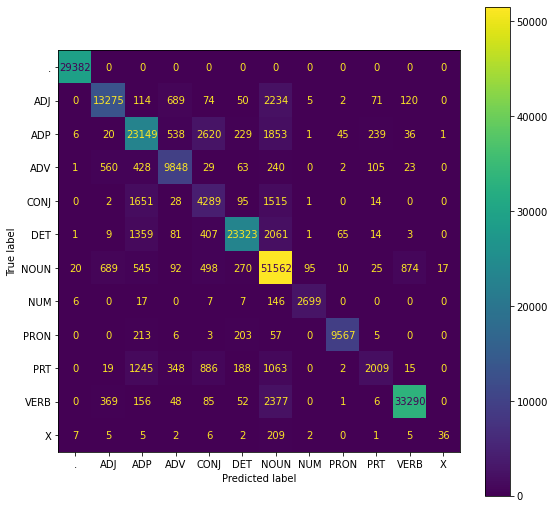

In [317]:
# cm = metrics.confusion_matrix(true,pred)
# print(cm)
# metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = preprocess(myTagger.tagset)).plot(include_values = False)
disp = metrics.ConfusionMatrixDisplay.from_predictions( true, pred, labels=myTagger.tagset, display_labels=myTagger.tagset, values_format='') 
fig = disp.ax_.get_figure() 
fig.set_figwidth(9)
fig.set_figheight(9)  

In [323]:
frac = 0.2
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_val = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

cross_valdation_accuracies = np.zeros(5)

for k in range(5):
  tmp = np.floor(np.arange(n_total)/n_val)
  train_ids = indices[ tmp != k ]
  val_ids = indices[ tmp == k ]
  
  train_sents = all_sentences[ train_ids ]
  val_sents = all_sentences[ val_ids ]

  myTagger = POS_tagger(train_sents)
  myTagger.train()

  pred = []
  true = []
  for sentence in val_sents:
    sentence = np.array(sentence)
    true = true + list(sentence[:,1])
    if len(sentence) == 1:
      pred = pred + ["."]
    else:
      pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

  from sklearn import metrics
  cm = metrics.confusion_matrix(true,pred)

  cross_valdation_accuracies[k] = np.trace(cm)/np.sum(cm)

In [334]:
print(cross_valdation_accuracies)
print(cross_valdation_accuracies.mean())

[0.87561114 0.87596567 0.87261018 0.87310012 0.87427426]
0.874312272569504
